# K-means Clustering

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time

In [3]:
# Read example dataset

x = np.load('X.npy')
y = np.load('y.npy').reshape(-1,1)

toy_dataset = np.concatenate((x,y),axis=1)

---
### k-means implementation

    In the following cell you can find a object oriented implementation of the kmeans algorithm. Specifically, the following methods are implemented:
* `__init__(self,K,init_method)`: Initializes the kmeans' object attributes (**k**: number of clusters, **init_method**: {random,kmeans++})

* `fit(self,data,num_restarts)`: After the initilizating the centroids according to the chosed **init_method**, this method runs the k-means assignment and update step **num_restart** times. The goal is to **minimize within cluster variation**:$$
\sum_{k=1}^{K}\frac{1}{|C_{k}|}\sum_{\underset{x_{i}\in c_{k}}{i=1}}^{n}||x_{i}-c_{k}||_{2}^{2} (1)$$
where $C={C_1,C_2,...,C_k} $ denote the centroids. One can easily access the results using attribute **y** (numpy array containing where each input point is assigned), the centroids using the **centroids** attribute and the withing cluster variation of the best solution out of all the num_restarts runs using **best_sol**.

* `predict(self,data)`: Given a test set (data), returns a numpy array containing the assignment of the points of it on the clusters created by **fit**.

* `plot_results(self,data)`: Plots the given data points at a scatterplot, with each clustering having a distinct color. Additionally, initial clusters and clusters of the best solution are plotted.

* `calculate_euclidian_distance(self,a,b)`: Returns the euclidian distance between point a and b.

* `def calculate_solution_penalty(self,x,y,centroids)`: Return the Within Cluster Variation of assignment y on input x.

initial centroids: [[-0.73302679 -1.36224352]
 [-0.58958395 -1.67912639]
 [-0.90822693 -1.48877197]
 [-0.57716881 -1.87842906]
 [-0.41648903 -1.26012943]
 [-0.08260325 -1.52552743]
 [-0.45789569 -1.49498757]
 [-0.27325143 -1.08008313]
 [-0.4557259  -1.96194903]]
centroids: [[ 5.62525397 -2.72659492]
 [ 9.09635079 -8.37293878]
 [ 4.42594945 -8.49059858]
 [ 0.88991824 -0.83332728]
 [ 1.14502421  0.4472683 ]
 [-1.50748683  1.60406804]
 [-0.78326678  5.21513464]
 [-8.06414959  7.0697321 ]
 [-7.24599437 -3.86666021]]
Within Cluster Variation: 13.643741151449216


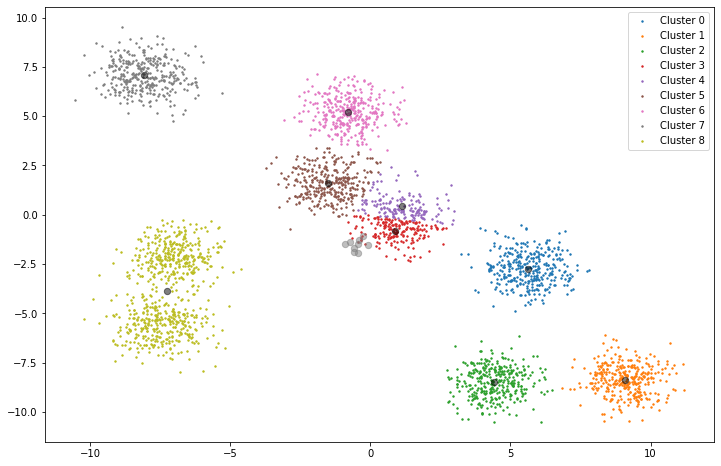

In [38]:
class KMeansClustering():
    '''
    An object-oriented implementation of KMeans Clustering.
    '''
    
    def __init__(self,K,init_method):
        '''
        Initialization of class.
        K: number of clusters
        init_method: {'random','kmeans++''}
        '''
        
        # Assign/Initialize attributes
        
        self.K = K 
        
        self.y = np.array([]) # clusters of train set
        
        self.centroids = np.array([]) # centroids of train set
        
        self.initial_centroids = np.array([]) # initial centroids of train set
        
        self.best_sol = np.inf # within cluster distance of solution
        
        # Error handling for initialization method
        
        if init_method == 'random' or init_method == 'kmeans++':
            
            self.init_method = init_method
            
        else:
            
            raise ValueError(f'Initialization method {init_method} not supported.')
        
    def fit(self,data,num_restarts):
        '''
        Run the algorithm num_restarts times.
        '''
         
        # Repeat the aglorithm num_restarts times
        
        store_initial_centroids = False
        
        for repeat in range(num_restarts):
        
            # Initialization step

            if self.init_method == 'random':

                # Assign points to random cluster

                y = np.random.randint(0,self.K,size=(data.shape[0],1))
                
                store_initial_centroids = True

            elif self.init_method == 'kmeans++':
                
                y = np.zeros((data.shape[0],1))
                
                # Choose randomly the first centroid

                first_centroid = np.random.randint(0,data.shape[0])
                
                centroids = np.zeros((self.K,data.shape[1]))
                
                centroids[0,:] = data[first_centroid,:]
                
                centroid_indexes_from_input = [first_centroid] # This will make sure we do not choose the same point more tha one times
                
                # Find the rest of the centroids
                
                for k in range(1,self.K):
                    
                    # For each datapoint, find the min distance from a centroid
                    
                    min_dist = np.full((data.shape[0],1), np.Inf)
                    
                    for i in range(x.shape[0]):
                        
                        if i in centroid_indexes_from_input: continue
                        
                        for c in range(0,k):
                            
                            if self.calculate_euclidian_distance(data[i,:],centroids[c,:]) < min_dist[i]:
                                
                                min_dist[i] = self.calculate_euclidian_distance(data[i,:],centroids[c,:])
                                
                    # At this point we know that min_dist contains min dist of this point
                        
                    min_dist[min_dist == np.Inf] = 0

                    min_dist = min_dist ** 2
                        
                    # Use random to make a weighted random choice
                        
                    new_centroid = random.choices(list(range(x.shape[0])),weights=tuple(min_dist),k=1)

                    while( new_centroid in centroid_indexes_from_input ):

                        new_centroid = random.choices(list(range(x.shape[0])),weights=tuple(min_dist),k=1)

                    centroids[k,:] = data[new_centroid,:]

                    centroid_indexes_from_input.append(new_centroid)
                    
                self.initial_centroids = centroids
                        
                # At this point, all k clusters have been initialized with kmeans++
                # Now, lets assing the points:
                
                y = np.zeros((x.shape[0],1))

                # Find the closest centroid for each datapoint and assign the point to it

                for i in range(x.shape[0]):

                    min_dist = self.calculate_euclidian_distance(data[i,:],centroids[0,:])

                    closest_centroid = 0

                    for c in range(1,self.K):

                        if self.calculate_euclidian_distance(data[i,:],centroids[c,:]) < min_dist:

                            closest_centroid = c

                            min_dist = self.calculate_euclidian_distance(data[i,:],centroids[c,:])

                    y[i] = closest_centroid
                
            else:

                raise ValueError(f'Model has to be initialized first.')
            
            # K-means loop

            while(1):

                # Compute new centroids

                centroids = np.zeros((self.K,data.shape[1]))    

                # For each centroid...

                for i in range(self.K):

                    indexes = np.where(y == i)[0]

                    # Find mean of each feature of points belonging in the same cluster

                    for feature in range(data.shape[1]):

                        sum4mean = 0.0

                        for l in indexes:

                            sum4mean = sum4mean + data[l,feature]

                    # Update centroid feature with mean

                        if len(indexes) > 0:

                            centroids[i,feature] = sum4mean / indexes.shape[0]
                            
                if store_initial_centroids == True:
                    
                    self.initial_centroids = centroids
                    
                    store_initial_centroids = False

                # Assignment step

                y_new = np.zeros(y.shape)

                # Find the closest centroid for each datapoint and assign the point to it

                for i in range(x.shape[0]):

                    min_dist = self.calculate_euclidian_distance(data[i,:],centroids[0,:])

                    closest_centroid = 0

                    for c in range(1,self.K):

                        if self.calculate_euclidian_distance(data[i,:],centroids[c,:]) < min_dist:

                            closest_centroid = c

                            min_dist = self.calculate_euclidian_distance(data[i,:],centroids[c,:])

                    y_new[i] = closest_centroid

                # the algorithm finishes if no points change cluster

                if np.array_equal(y_new,y): break
                else: y = y_new

            value2optimize = self.calculate_solution_penalty(data,y,centroids)

#             print(value2optimize)

#             print(centroids)

            # Store the best values

            if value2optimize < self.best_sol:

                self.best_sol = value2optimize

                self.y = y

                self.centroids = centroids

        
    def predict(self,data):
        '''
        Returns the closest cluster for each data point in given data.
        '''
        
        y = np.zeros((data.shape[0],1))
        
        print(y.shape)
        
        for i in range(data.shape[0]):

            min_dist = self.calculate_euclidian_distance(data[i,:],self.centroids[0,:])

            closest_centroid = 0

            for c in range(1,self.K):
                
                if self.calculate_euclidian_distance(data[i,:],self.centroids[c,:]) < min_dist:

                    closest_centroid = c

                    min_dist = self.calculate_euclidian_distance(data[i,:],self.centroids[c,:])

            y[i] = closest_centroid
                 
        return y
    
    def plot_results(self,data):
        '''
        Plot given data with assignment y.
        '''
        
        plt.figure(figsize=(12,8))
        
        # Plot clusters with different colours
        
        for i in range(0,self.K):
            
            indices = np.where(self.y == i)[0]
            
            plt.scatter(data[indices,0],data[indices,1],s=2,label=f"Cluster {i}")
            
        # If centroids have been initialized, print them too
            
        if not np.array_equal(self.centroids,np.zeros((self.K,self.K))):

            for i in range(self.centroids.shape[0]):

                plt.scatter(self.centroids[i,0],self.centroids[i,1],alpha=0.5,s=40,c='black',label="Centroids")
                
        # Plot also the initial value for the centroids

            for i in range(self.initial_centroids.shape[0]):

                plt.scatter(self.initial_centroids[i,0],self.initial_centroids[i,1],alpha=0.5,s=40,c='gray',label="Initial centroids")
        
        legend = [str(f'Cluster {i}') for i in range(self.K)]
        
        plt.legend(legend)

    def calculate_euclidian_distance(self,a,b):
        '''
        Returns the euclidian distance between vectors a and b.
        '''
        
        a_new = a.reshape(-1,1)
        
        b_new = b.reshape(-1,1)
        
        dist = 0
        
        for i in range(0,a_new.shape[0]):
            
            dist = dist + (a_new[i]-b_new[i])**2
        
        return dist
    
    def calculate_solution_penalty(self,x,y,centroids):
        '''
        Returns the Within Cluster Variation of solution/assignment y.
        '''
    
        sum2return = 0
        
        for k in range(0,self.K):
            
            indices = np.where(y == k)[0]
            
            sum2temp = 0
        
            for i in indices:
            
                for f in range(x.shape[1]):

                    sum2temp = sum2temp + (x[i,f] - centroids[int(y[i]),f])**2

            sum2return = sum2return +  sum2temp/len(indices)
            
        return sum2return 
    
# Execute methods on toy dataset
        
model = KMeansClustering(9,'random')
model.fit(x,12)
model.plot_results(x)
print(f'initial centroids: {model.initial_centroids}')
print(f'centroids: {model.centroids}')
print(f'Within Cluster Variation: {model.best_sol}')

#### The effect of K

In order to choose a good value for k, we are going to run the algorithm multiple times.

In [84]:
possible_ks = list(range(2,21))

# The following will be used to store the solution of the best k

best_model = KMeansClustering(1,'random')

best_model.fit(x,10)

within_cluster_var = [best_model.best_sol]

for k in possible_ks:
    
    # Initialze a new model
    
    new_model = KMeansClustering(k,'random')
    
    # Run the algorithm
    
    new_model.fit(x,4)
    
    # Check whether it is a better solution than our best up to this point
    
    if new_model.best_sol < best_model.best_sol:
        
        best_model = new_model
        
    within_cluster_var.append(new_model.best_sol)
    
    print(k,end='\t')
    

2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	

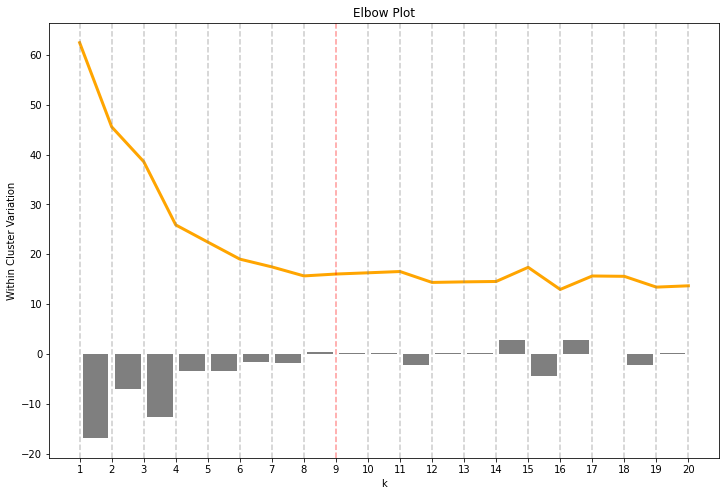

In [85]:
# Plot within cluster variaton per k

possible_ks = list(range(1,21))

plt.figure(figsize=(12,8))

plt.plot(possible_ks,within_cluster_var,color='orange',linewidth=3)

plt.xticks(possible_ks)

plt.xlabel('k')

plt.ylabel('Within Cluster Variation')

# Plot vertical lines for each potential value of k

for i in list(range(1,21)):
    
    if i != 9:
    
        plt.axvline(x = i,color = 'gray',ls='--',alpha=0.4)
        
    else:
        
        plt.axvline(x = i,color = 'red',ls='--',alpha=0.4)
    
# Bar plot to show the difference between censecutive values for k

differences = [within_cluster_var[i+1]-within_cluster_var[i] for i in list(range(0,19))]

# print(len(differences))

plt.bar([i+0.5 for i in list(range(1,20))],differences,alpha=0.5,color='black')

plt.title('Elbow Plot')

plt.show()

The bars between the dotted lines show the difference in WCV between consequtive values of k. We know that optimal value is 9, and that can be confirmed by the above Elbow plot.

#### The effect of initialization

One of the problems that k-means suffers from is that it depends a lot on the quality of the initialization. Having a bad initialization will surely lead to bad results, even when choosing the right number for k. In order to counter this, we may use the **k-means++** initialization method instead of the random default one. In short, k-means++ chooses points that are more likely to be far away from each other, which in turn forces the centroids to spread out and hopefully yield better results.

initial centroids: [[ 9.1685044  -8.63350128]
 [-6.94860823  7.43555326]
 [-0.81978379  4.64658894]
 [-5.8175693  -0.80309518]
 [ 3.68740719 -7.63765299]
 [-0.50521534  1.90922536]
 [ 6.69482082 -1.6460108 ]
 [-9.26200903 -4.31865375]
 [-5.73124369 -3.59970765]]
centroids: [[ 4.42594945 -8.49059858]
 [-8.06414959  7.0697321 ]
 [ 9.09635079 -8.37293878]
 [-7.4794886  -5.61317693]
 [-1.44006381  1.59218649]
 [ 5.62525397 -2.72659492]
 [-7.00967845 -2.09903756]
 [-0.78326678  5.21513464]
 [ 1.04288974 -0.32721825]]
Within Cluster Variation: 11.349354545020606


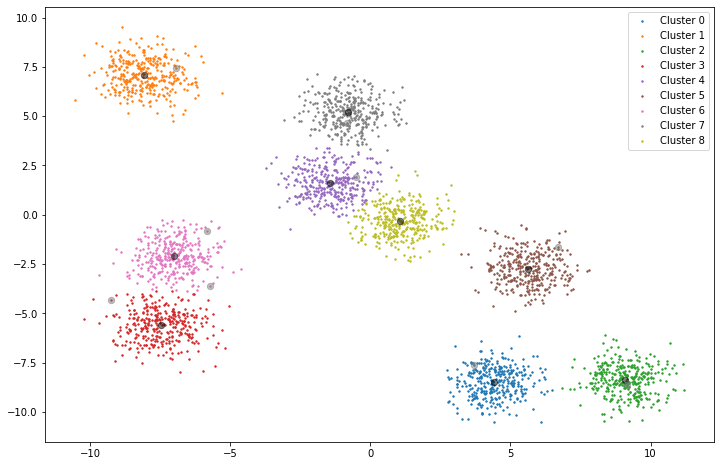

In [39]:
# Execute kmeans++ initialization on toy dataset
        
model = KMeansClustering(9,'kmeans++')
model.fit(x,6)
model.plot_results(x)
print(f'initial centroids: {model.initial_centroids}')
print(f'centroids: {model.centroids}')
print(f'Within Cluster Variation: {model.best_sol}')

Clearly, using k-means++ as an initialization improves the quality of the clustering.
___
## Comparing random and k-means++ initialization in multiple runs

In [87]:
# Running K-means 800 times

random_within_cluster_metric = np.zeros(((800,1)))

kmeansplusplus_within_cluster_metric = np.zeros((800,1))

random_within_cluster_time = np.zeros(((800,1)))

kmeansplusplus_within_cluster_time = np.zeros((800,1))

for i in range(801):
    
    # Random initialization experiment
    
    begin = time.time()
    
    model = KMeansClustering(9,'random')

    model.fit(x,1)
    
    end = time.time()
    
    random_within_cluster_metric[i] = model.best_sol
    
    random_within_cluster_time[i] = end - begin
    
    # K-means initialization experiment
    
    begin = time.time()
    
    model = KMeansClustering(9,'kmeans++')

    model.fit(x,1)
    
    end = time.time()
    
    kmeansplusplus_within_cluster_metric[i] = model.best_sol
    
    kmeansplusplus_within_cluster_time[i] = end - begin
    
    print(i,end='\t')

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100	101	102	103	104	105	106	107	108	109	110	111	112	113	114	115	116	117	118	119	120	121	122	123	124	125	126	127	128	129	130	131	132	133	134	135	136	137	138	139	140	141	142	143	144	145	146	147	148	149	150	151	152	153	154	155	156	157	158	159	160	161	162	163	164	165	166	167	168	169	170	171	172	173	174	175	176	177	178	179	180	181	182	183	184	185	186	187	188	189	190	191	192	193	194	195	196	197	198	199	200	201	202	203	204	205	206	207	208	209	210	211	212	213	214	215	216	217	218	219	220	221	222	223	224	225	226	227	228	229	230	231	232	233	234	235	236	237	238	239	240	241	242	243	244	245	246	247	248	249	250	251	252	253	254	255	256	257	258	259	260	261	262	263	264	265	266	267	268	269	270	271	272	273	274	275	276	27

In [92]:
# Pretty print results
print(f'Random Initialization (800 executions)\n======================================\nWithin Cluster Variation mean: {random_within_cluster_metric.mean()}\nWithin Cluster Variation deviation: {random_within_cluster_metric.std()}\nAverage time taken: {random_within_cluster_time.mean()}s\n')
print(f'Kmeans++ Initialization (800 executions)\n======================================\nWithin Cluster Variation mean: {kmeansplusplus_within_cluster_metric.mean()}\nWithin Cluster Variation deviation: {kmeansplusplus_within_cluster_metric.std()}\nAverage time taken: {kmeansplusplus_within_cluster_time.mean()}s')

Random Initialization (800 executions)
Within Cluster Variation mean: 16.747194130975924
Within Cluster Variation deviation: 1.8622174773357647
Average time taken: 4.852362553477287s

Kmeans++ Initialization (800 executions)
Within Cluster Variation mean: 12.368743284325971
Within Cluster Variation deviation: 1.2624489192314432
Average time taken: 3.5157758623361586s



* One can easily notice the improvement in quality when using k-means++ as an initialization method by viewing the lower average WCV.

* Moreover, the standard deviation of WCV is smaller, which translates in consistency in the quality of the results.

* Finally, another advantage of the K-means++ (unexpectedly as k-means on first glance seems to be more time-consuming), turns out to be the initialization time, as one can see in the average time taken per method.